# Time series clustering based on autocorrelation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess

/Users/willie/.local/share/virtualenvs/time-series-demos-svg3QhUy/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1 Generate time series dataset

In [2]:
# Define the ARMA processes. AR params must be negated. See
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
processes = [
    ArmaProcess.from_coeffs([0.0], [0.0]),
    ArmaProcess.from_coeffs([-0.5], [0.0]),
    ArmaProcess.from_coeffs([0.0], [0.9])
]

In [3]:
# Generate the time series.
df = pd.DataFrame()
for i in range(12):
    df[f"TS_{i}"] = processes[i // 4].generate_sample(500)

In [4]:
df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,0.068074,-0.653754,0.267624,0.418643,0.427407,0.047447,0.061018,-0.260027,-1.875752,-0.431688,-0.441995,-0.435461
1,-0.170392,0.854556,-0.904764,0.616546,-0.007733,0.203492,1.236594,-2.452234,-0.445023,-0.712079,0.548014,0.908058
2,-0.663262,-0.838068,1.253573,0.551845,-0.972882,-0.653326,-1.212452,1.925945,0.685276,-0.577059,0.576437,2.112609
3,-0.260708,-0.068910,1.099291,0.143317,-1.398980,1.221690,1.853399,-1.122461,-2.087616,-0.820105,-0.919755,0.459971
4,-0.844519,1.045736,-0.199573,-1.373390,1.793707,0.016830,1.407353,-0.396421,-0.840864,0.744641,-0.136404,-0.090019
5,-0.052515,-0.575619,-0.580459,-0.905988,-1.050683,0.381470,-2.501549,-0.127529,-1.392969,0.731084,-0.334022,-1.240838
6,0.352652,1.053698,1.342562,1.304720,-1.317042,0.690355,0.527686,1.454489,-2.151927,-1.954670,-1.458320,0.556334
7,0.615574,-0.508123,0.371611,-0.745282,2.822662,-0.390772,-0.675078,-0.605168,-1.290699,-0.984676,-1.800005,1.200801
8,1.589022,0.032320,-0.733644,-0.662287,-1.425691,0.131317,0.227740,0.229212,-0.813508,1.197837,-0.981913,-2.069769
9,1.232444,0.546621,0.765021,-0.682115,1.127743,-1.182633,0.596809,-0.210953,-1.186942,0.762249,-0.975361,-0.841623


In [5]:
def plot_df(df, lower, upper):
    title = f"TS {lower}-{upper}"
    df.iloc[:, lower:upper].plot(title=title, figsize=(12, 4), alpha=0.4)
    plt.show()

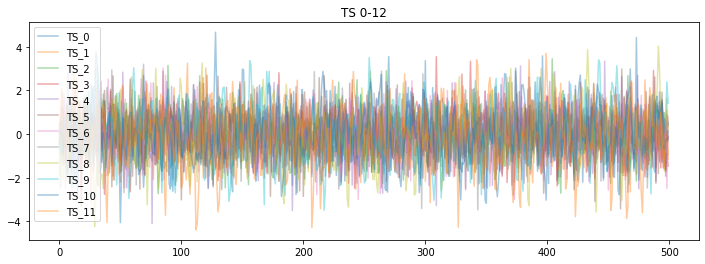

In [6]:
plot_df(df, 0, 12)

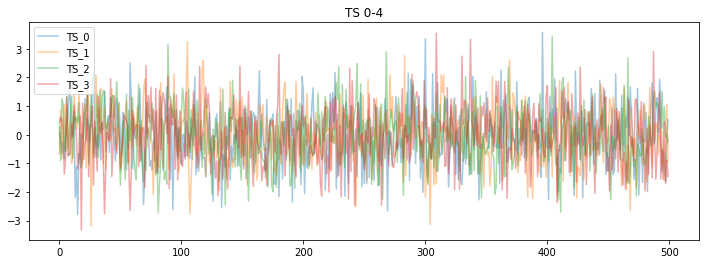

In [7]:
plot_df(df, 0, 4)

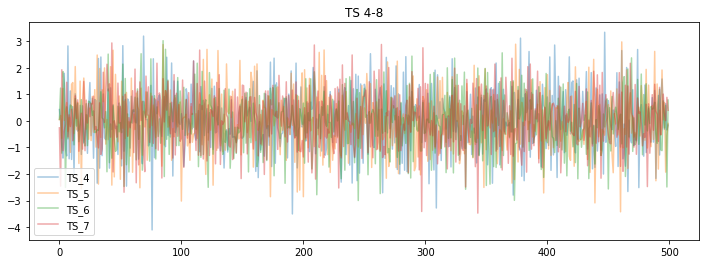

In [8]:
plot_df(df, 4, 8)

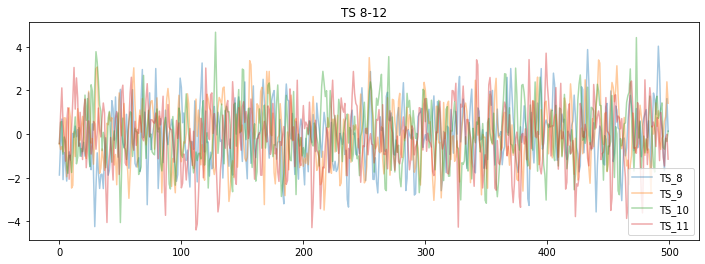

In [9]:
plot_df(df, 8, 12)

## 2 Estimate ACFs 

In [15]:
max_lag = 10
lag_arr = np.repeat(max_lag, df.shape[1])
acf_df = pd.DataFrame(list(map(sm.tsa.acf, df.transpose().to_numpy(), lag_arr))).transpose()

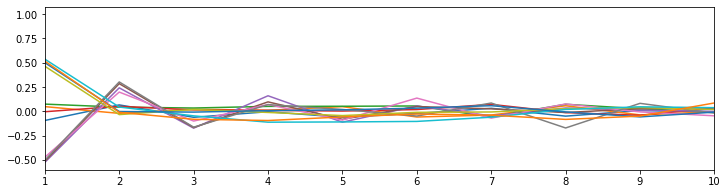

In [16]:
plt.figure(figsize=(12, 3))
plt.xlim((1, max_lag))
plt.plot(acf_df)
plt.show()

## 3 Find clusters

In [13]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(acf_df.transpose())
kmeans.labels_

array([2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

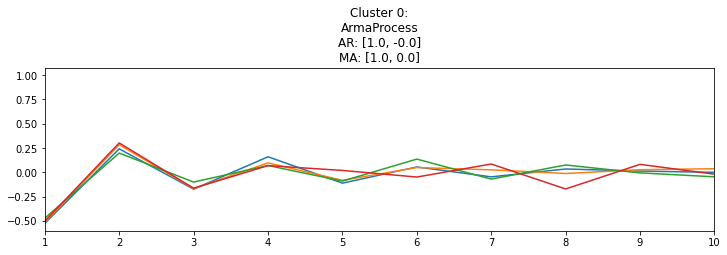

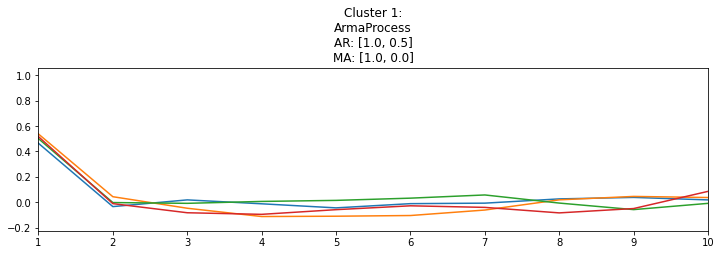

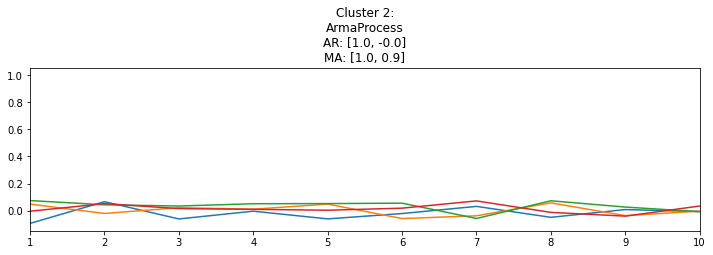

In [18]:
for i in range(3):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, max_lag))
    for j in range(acf_df.shape[1]):
        if kmeans.labels_[j] == i:
            plt.title(f"Cluster {i}:\n{processes[i]}")
            plt.plot(acf_df.iloc[:, j])
    plt.show()